In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

import mcmc as xm
import gensynth as gs

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Generating synthetic samples

Let us create samples with specified $\Delta P(A, B)$ for the binary variables $A$ and $B$. For that we will recall that:

$$\Delta P(A, B) \equiv P(A=1|B=1) - P(A=1).$$

For generating the synthetic $(A, B)$ samples, we need to recall that, from the law of total probability:

$$P(A=1|B=0) = \frac{P(A=1) - P(A=1|B=1)P(B=1)}{P(B=0)}$$.

When generating data with a given $\Delta P(A,B)$, $P(A)$ and $P(B)$ will be treated as nuisance parameters. 

In [3]:
# \Delta P(A,B), P(A), P(B), N_samples:
settings = [(0.0, 0.7, 0.2, 50), (-0.1, 0.7, 0.2, 50), (0.1, 0.7, 0.2, 50), (0.6, 0.4, 0.2, 50), (-0.6, 0.7, 0.2, 50),
            (0.0, 0.7, 0.2, 1000), (-0.1, 0.7, 0.2, 1000), (0.1, 0.7, 0.2, 1000), (0.6, 0.4, 0.2, 1000), (-0.6, 0.7, 0.2, 1000)]

## Basic tests

In [4]:
# Test: result must be the same as Pa:
Pa = 0.6
Pb = 0.2
b0, b1 = gs.compute_cond_probs(-0.5, Pa, Pb)
b0 * (1 - Pb) + b1 * Pb

0.6

In [6]:
# Check if generated P(A) and P(B) are ok:
s = settings[5]
a_arr, b_arr = gs.gen_sample(*s)
print(s[1], a_arr.mean())
print(s[2], b_arr.mean())

0.7 0.72
0.2 0.203


## Running the chains

In [7]:
# Run chains for all cases:
chains = []
for s in settings:
    a_arr, b_arr = gs.gen_sample(*s)
    df = pd.DataFrame({'A': a_arr, 'B': b_arr})
    chain_df = xm.mcmc_sample_multinomial_pars(df, 'A', 'B')
    chains.append(chain_df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 25 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 9 seconds.


In [11]:
# Save chains:
if False:
    for i, cdf in enumerate(chains):
        cdf.to_csv('../data/sim_chains/chain_{:02d}.csv'.format(i), index=False)

## Loading chains

In [15]:
# Load previously saved chains:
if True:
    chains = [pd.read_csv('../data/sim_chains/chain_{:02d}.csv'.format(i)) for i in range(10)]

## Plot the posteriors

In [33]:
# Select a subset of the chains:
selection = [0, 1, 2, 3, 4, 5, 6, 8]
sel_settings = [settings[i] for i in selection]
sel_chains = [chains[i] for i in selection]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


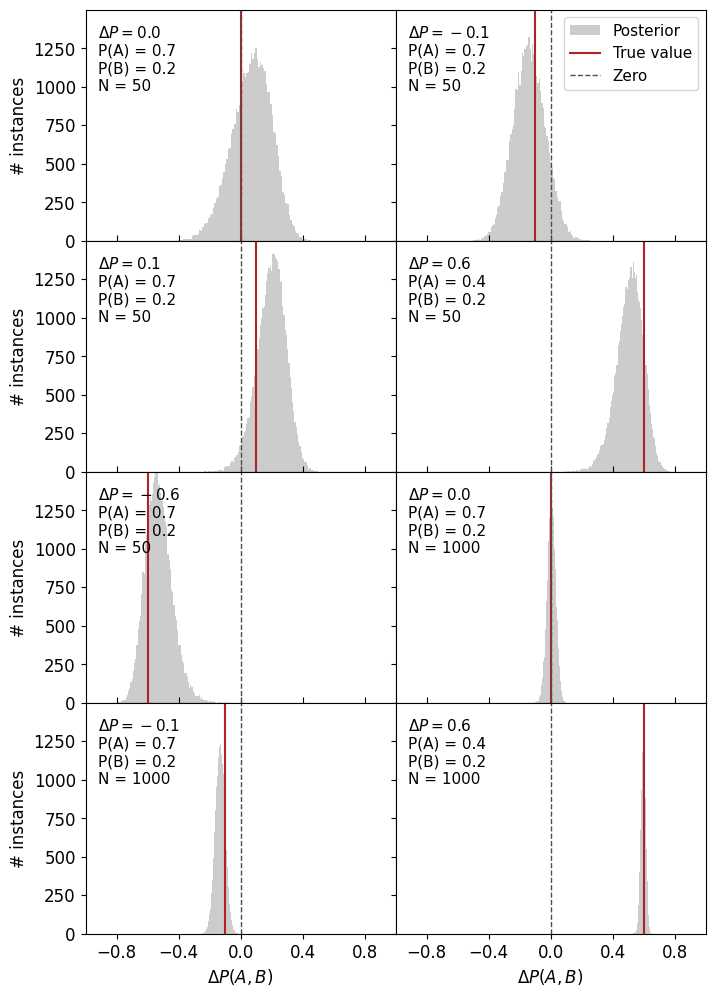

In [90]:
fsize = 12
pl.figure(figsize=(8,12))
for i in range(len(sel_settings)):
    ax = pl.subplot(4, 2, i + 1)
    ss = sel_settings[i]
    # Plot:
    sel_chains[i]['sPa'].hist(bins=100, color='0.8', grid=False, label='Posterior')
    pl.axvline(ss[0], color='firebrick', label='True value')
    pl.axvline(0, color='0.3', label='Zero', linewidth=1, linestyle='--')
    pl.xlim([-1,1])
    pl.ylim([0,1500])
    # Text:
    info = '$\Delta P = {}$\nP(A) = {}\nP(B) = {}\nN = {}'.format(ss[0], ss[1], ss[2], ss[3])
    pl.text(-0.92, 1400, info, va='top', fontsize=11)
    # Format:
    ax.yaxis.set_tick_params(labelsize=fsize)
    ax.xaxis.set_tick_params(labelsize=fsize)
    pl.xticks([-0.8, -0.4, 0.0, 0.4, 0.8])
    pl.yticks(range(0, 1500, 250))
    if i % 2 == 0:
        pl.ylabel('# instances', fontsize=fsize)
    else:
        ax.yaxis.set_tick_params(labelleft=False)
    if i > 5:
        pl.xlabel('$\Delta P(A, B)$', fontsize=fsize)
    else:
        ax.xaxis.set_tick_params(direction='inout', length=8)
        ax.xaxis.set_tick_params(labelleft=False)
    
    
    # Legend:
    if i == 1:
        pl.legend(fontsize=11, loc='upper right')
pl.subplots_adjust(hspace=0, wspace=0)
#pl.savefig('plots/synthetic_posteriors.eps', bbox_inches='tight')